## Gaussian Mixture Model (GMM) 
In this experiment, we demonstrate how to determine the data distribution using GMM. 
The first experiment uses scipy library. This will be used to verify the implementation of Expectation Maximization (EM) algorithm in learning the parameters of GMM.
The second experiment uses EM as discussed in the lecture notes.
The results on both experiments are consistent.

Let us generate synthetic data first using 2 Gaussians.

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300
n_components = 2

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

## GMM using Scikit Learn

Reference: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py

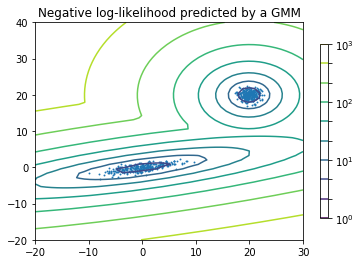

In [258]:

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

## GMM using Expectation Maximization (EMM)
1. Initialize mean, covariance matrix, and weights
2. E-Step: Compute Responsibilities
![responsibilities](respon.png)
3. M-Step: Update mean, covariance matrix, and weights
![responsibilities](mean.png)
4. Go to step 2

mu: [[-0.13607006 -0.07059606]
 [19.91453549 19.97556345]]
sigma: [[[1.13328030e+01 2.25048269e+00]
  [2.25048269e+00 8.77008968e-01]]

 [[1.02179864e+00 3.28158679e-03]
  [3.28158679e-03 9.90374215e-01]]]
pi [[0.5]
 [0.5]]


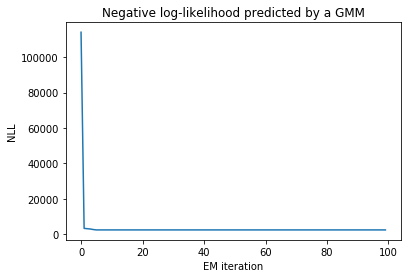

In [261]:
from scipy.stats import multivariate_normal

n_dim = 2
# Initialize parameters
mu_shape = (n_components, n_dim)
mu = np.random.normal(size=mu_shape)
sigma = [np.identity(n_dim) for _ in range(n_components)]
sigma_shape = np.array(sigma).shape
pi = np.ones((n_components,1))/n_components

n_loop = 100
nll = []

for loop in range(n_loop):
    # Compute N train data
    # n_component n_dim Gaussian
    rv = [multivariate_normal(mu[i], sigma[i]) for i in range(n_components)]
    g_val = np.array([rv[i].pdf(X_train) for i in range(n_components)])
    
    # Negative log-likelihood
    weighted_g_val = np.array([pi[i]*rv[i].pdf(X_train) for i in range(n_components)])
    weighted_g_val = np.log(weighted_g_val.sum(axis=0)).sum()
    nll.append(-weighted_g_val)
    
    # Compute Responsibilities
    # n_components x n_samples
    p = np.repeat(pi, X_train.shape[0], axis=1)
    # n_components x n_samples
    # pi * N (denominator of rnk)
    g_val_sum = np.multiply(p, g_val)
    # for all k
    g_val_sum = g_val_sum.sum(axis=0)
    
    # reshape to 1 x n_samples
    g_val_sum = np.reshape(g_val_sum, (-1, g_val_sum.shape[0]))
    
    # repeat rows, 2 x n_samples
    g_val_sum = np.repeat(g_val_sum, n_components, axis=0)
    
    
    # pi x N
    r = np.multiply(p, g_val)
    # pik x N / Sum_k (pik x N)
    r = np.divide(r, g_val_sum)
  
    
    # Compute Nk
    # Nk shape (2,)
    Nk = r.sum(axis=1)
    # 4,
    Nk = np.repeat(Nk, n_components, axis=0)

    # Update Means
    r = np.repeat(r, n_components, axis=0)
    x_t = [X_train.transpose() for _ in range(n_components)]
    x_t = np.concatenate(x_t, axis=0)
    # responsibilities x data
    mu = np.multiply(r, x_t).sum(axis=1)
    # divide by Nk for all k
    mu = np.divide(mu, Nk)
    # reshape for sigma computation
    mu = np.reshape(mu, [-1, 1])
    
    # Update Covariance Matrices
    # data - means or centered data
    x_t = x_t - mu
    x_tt = x_t
    # responsibilities x data
    x_t = np.multiply(x_t, r)
    # 
    x_t = np.reshape(x_t, (n_components, n_dim, -1))
    x_tt = np.reshape(x_tt, (n_components, n_dim, -1))
    # outer product of weighted centered data and centered data 
    sigma = [np.matmul(x_t[i], x_tt[i].transpose()) for i in range(x_t.shape[0])]
    
    # outer product divide by Nk for all k
    N = np.reshape(Nk, (-1,1))
    N = np.repeat(N, n_components, axis=1)
    N = np.reshape(N, (n_components, n_components, -1))
    sigma = [np.divide(sigma[i], N[i]) for i in range(n_components)]
    
    # Update pi
    Nk = Nk[::2]
    Nk = np.reshape(Nk, pi.shape)/X_train.shape[0]
    pi = np.reshape(Nk, pi.shape)
    
    # Restore Means and Cov to right shapes
    mu = np.reshape(mu, mu_shape)
    sigma = np.reshape(np.array(sigma), sigma_shape)
    
    # Should be the means and covs of the sampled and mixed Gaussians
    if loop == n_loop - 1:
        print("mu:", mu)
        print('sigma:', sigma)
        print('pi', pi)
        
x = [loop for loop in range(n_loop)]
plt.plot(x,nll)
plt.title('Negative log-likelihood predicted by a GMM')
plt.xlabel('EM iteration')
plt.ylabel('NLL')
plt.show()

## Performance Benchmark
Using a similar benchmark as in scipy example, we compute and plot the the negative log-likelihood of test samples

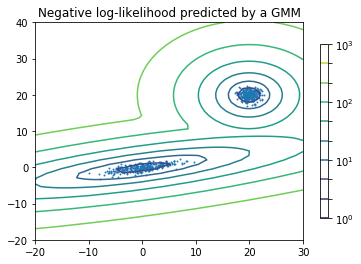

In [262]:
rv = [multivariate_normal(mu[i], sigma[i]) for i in range(n_components)]

# Negative log-likelihood
nll = []
weighted_g_val = np.array([pi[i]*rv[i].pdf(XX) for i in range(n_components)])
weighted_g_val = weighted_g_val.sum(axis=0)
eps = 1e-200
weighted_g_val[ weighted_g_val < eps ] = eps
weighted_g_val = -np.log(weighted_g_val)

Z = weighted_g_val.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()
